In [24]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import pymbar
import seaborn as sns
from matplotlib import ticker
from pymbar import timeseries

import extq

In [4]:
sys.path.insert(1, "../python")
sys.path.insert(1, "../..")
import plotting
import util

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [6]:
REMD_DIR = {
    pot: f"/project2/roux/shenr/old_project/remdus-wt-3.550-nonbfix/remdus-wt-3.550-nonbfix-191wins-{pot}/output"
    for pot in ("neutral", "positive", "negative")
}
DATA_DIR = "/project/dinner/scguo/ci-vsd/data/rong_remd"

# MBAR analysis (neutral)

In [8]:
pot_energies = np.load(f"{DATA_DIR}/pot_energies.npy")
cvs = np.load(f"{DATA_DIR}/cvs.npy")
print(pot_energies.shape, cvs.shape)

(191, 30000) (191, 30000, 4)


(array([1.530000e+02, 7.121000e+03, 1.202030e+05, 7.785110e+05,
        1.966513e+06, 1.961274e+06, 7.690030e+05, 1.200140e+05,
        7.034000e+03, 1.740000e+02]),
 array([-109689.68042015, -109487.07033994, -109284.46025974,
        -109081.85017953, -108879.24009932, -108676.63001912,
        -108474.01993891, -108271.4098587 , -108068.7997785 ,
        -107866.18969829, -107663.57961808]),
 <BarContainer object of 10 artists>)

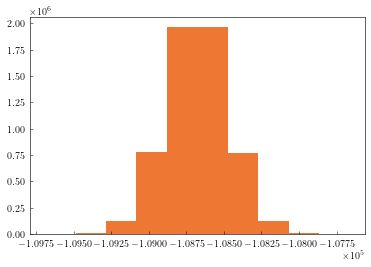

In [9]:
plt.hist(pot_energies.flatten())

In [10]:
dq = np.load("/project/dinner/scguo/ci-vsd/data/rong_remd/dq.npy")

(array([  554., 28893., 76826., 96508., 86072., 72428., 82503., 50436.,
        75146.,  3634.]),
 array([-5.92043074, -5.47488126, -5.02933177, -4.58378229, -4.1382328 ,
        -3.69268331, -3.24713383, -2.80158434, -2.35603486, -1.91048537,
        -1.46493588]),
 <BarContainer object of 10 artists>)

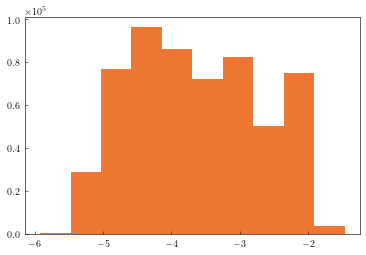

In [11]:
plt.hist(dq.flatten())

In [12]:
# umbrella centers and force constants
xmin, xmax, deltax, is_x_periodic = -10, 9.0, 0.2, 0
ymin, ymax, deltay, is_y_periodic = -140, 90, 2.5, 0
nwin, niter, fifreq = 191, 10000, 10
tol = 1e-3
nbinx = int((xmax - xmin) / deltax + 0.5)
nbiny = int((ymax - ymin) / deltay + 0.5)
temperature = 300
kb = 0.0019872
kbt = kb * temperature  # in kcal / mol
beta0 = 1.0 / kbt


k1 = np.zeros(nwin)  # spring constant for translocation
cx1 = np.zeros(nwin)  # harmonic center for translocation
k2 = np.zeros(nwin)  # spring constant for rotation
cx2 = np.zeros(nwin)  # harmonic center for rotation
hist = np.zeros((nwin, nbinx, nbiny), dtype=int)
nb_data = np.zeros(nwin, dtype=int)
x1 = lambda j: xmin + (j + 1) * deltax - 0.5 * deltax
y1 = lambda j: ymin + (j + 1) * deltay - 0.5 * deltay
press = 1.01325 * 1.4383 * 10**-5


data_range = [[None, None], [None, None], [None, None], [None, None]]

fp = open(f"{DATA_DIR}/metafile")
for i in range(nwin):
    # line = input.readline().strip()
    line = fp.readline().strip()
    fname = line.split()[0]
    cx1[i], cx2[i], k1[i], k2[i] = map(float, line.split()[1:5])

In [13]:
print(cx1[0], cx2[0], k1[0], k2[0])

-9.0 -115.0 5.0 0.02


In [14]:
N_max = pot_energies.shape[1]  # max number of frames from window
N_k = np.ones(nwin, dtype=int) * N_max  # N_k[k] is the number of snapshots from umbrella simulation k

ds_kn = np.zeros((nwin, N_max, 2), dtype=float)  # ds[k, n] is the
u_kn = np.zeros(
    (nwin, N_max), dtype=float
)  # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
g_k = np.zeros(nwin, dtype=int)  # number of uncorrelated samples per window

start_frame = 0
skip = 10
u_kn = u_kn[:, start_frame::skip]
ds_kn = cvs[:, start_frame::skip, :2]
N_max = u_kn.shape[1]
N_k = np.ones(nwin, dtype=int) * N_max

In [18]:
u_kln = np.zeros((nwin, nwin, N_max), dtype=float)
for k in range(nwin):
    for l in range(nwin):
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k, l] = u_kn[k] + 0.5 * beta0 * (
            k1[l] * (ds_kn[k, :, 0] - cx1[l]) ** 2 + k2[l] * (ds_kn[k, :, 1] - cx2[l]) ** 2
        )

In [19]:
u_kln.shape

(191, 191, 3000)

In [20]:
mbar = pymbar.MBAR(u_kln, N_k, verbose=True)

# show PMF along x/y

In [180]:
results = mbar.compute_expectations(ds_kn[..., 0])

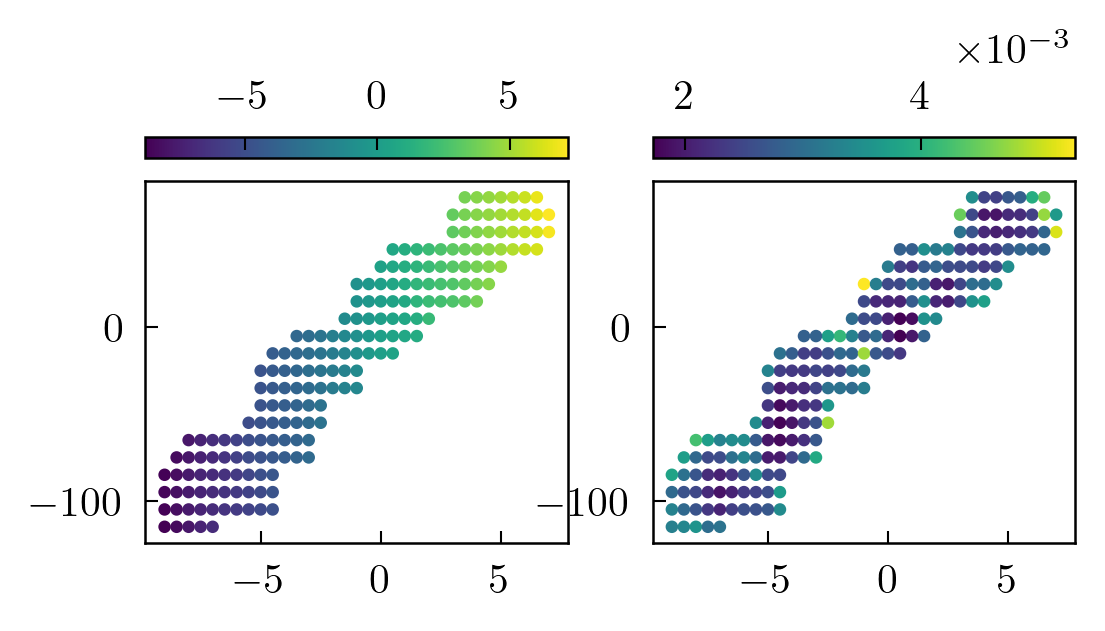

In [181]:
plt.figure(dpi=300, figsize=(4, 2))
ax = plt.subplot(121)
sc = ax.scatter(cx1, cx2, c=results["mu"])
plt.colorbar(sc, ax=ax, location="top")
ax2 = plt.subplot(122, sharex=ax, sharey=ax)
sc = ax2.scatter(cx1, cx2, c=results["sigma"])
plt.colorbar(sc, ax=ax2, location="top")

In [182]:
E_rot = mbar.compute_expectations(ds_kn[..., 1])

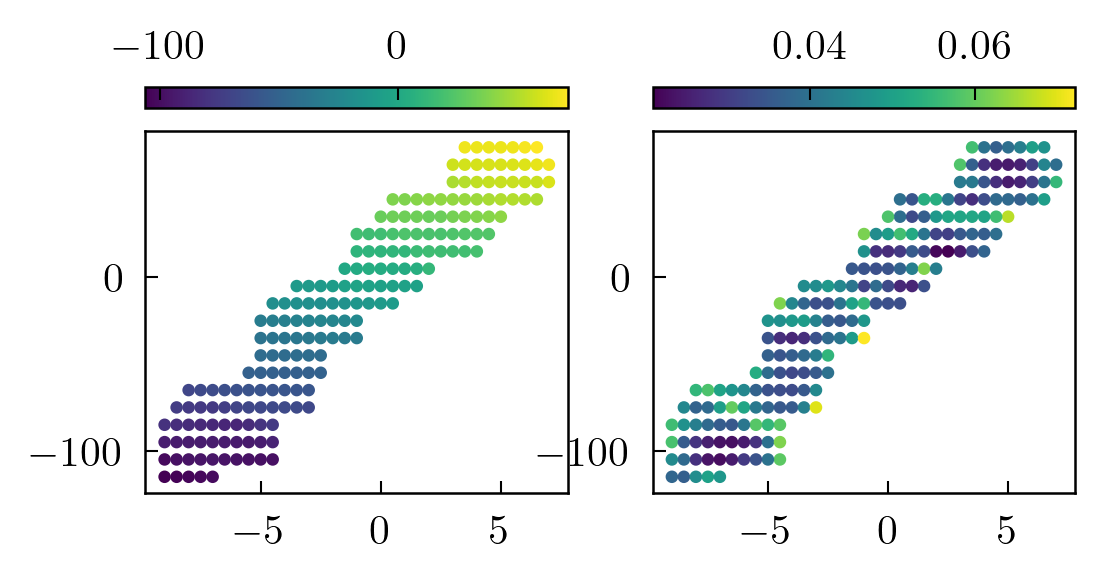

In [183]:
plt.figure(dpi=300, figsize=(4, 2))
ax = plt.subplot(121)
sc = ax.scatter(cx1, cx2, c=E_rot["mu"])
plt.colorbar(sc, ax=ax, location="top")
ax2 = plt.subplot(122, sharex=ax, sharey=ax)
sc = ax2.scatter(cx1, cx2, c=E_rot["sigma"])
plt.colorbar(sc, ax=ax2, location="top")

In [21]:
# Rong's reference REUS PMF data
pmf_ref = np.loadtxt(f"{DATA_DIR}/../wham2d_remd_neutral_30ns.dat")
# reshape into 2D data
pmf_ref = np.array(np.split(pmf_ref, 95, axis=0))
nx, ny, _ = pmf_ref.shape

In [22]:
# free energy is expectation of indicator on bins
xlim = pmf_ref[:, 0, 0]
ylim = pmf_ref[0, :, 1]

In [23]:
log_w_nb = mbar._computeUnnormalizedLogWeights(np.zeros(mbar.N)) # compute free energy with no bias
max_log_w_nb = np.max(log_w_nb)  # to prevent underflow.
w_nb = np.exp(log_w_nb - max_log_w_nb)
# w_nb = w_nb / np.sum(w_nb)  # normalize the weights

In [28]:
# dens, _, _ = np.histogram2d(
#     ds_kn[..., 0].flatten(), ds_kn[..., 1].flatten(), weights=w_nb, bins=[xlim, ylim]
# )
dens = extq.projection.density2d(ds_kn[..., 0], ds_kn[..., 1], w_nb.reshape((mbar.K, -1)), xlim, ylim) 

/scratch/local/jobs/5704280/ipykernel_1238939/1650888629.py:2: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens) - min_energy


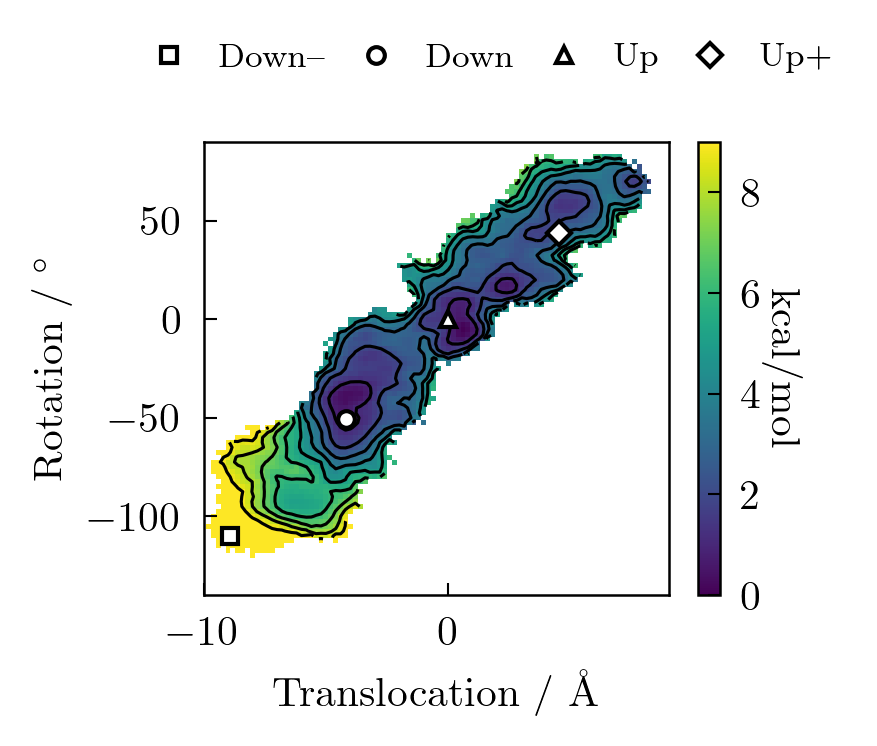

In [31]:
min_energy = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_energy

fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
pc = plt.pcolormesh(xlim, ylim, pmf.T * 0.593, vmax=9)
cb = plt.colorbar(pc)
cb.set_label("kcal/mol", rotation=-90, labelpad=10)
xc = (xlim[1:] + xlim[:-1]) / 2
yc = (ylim[1:] + ylim[:-1]) / 2
plt.contour(xc, yc, pmf.T * 0.593, colors='black', levels=np.arange(10))
plotting.format_cvs(ax, centroids=False, ms=4, zorder=5)
fig.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=0.5,
    handletextpad=0.5,
    fontsize=8,
)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xlabel("Translocation / Å")
ax.set_ylabel("Rotation / $^\circ$")
ax.label_outer()

In [36]:
qe = np.linspace(-5.5, -1.5, 101)
dens = extq.projection.density1d(dq, w_nb.reshape((mbar.K, -1)), qe)

(-0.5, 6.0)

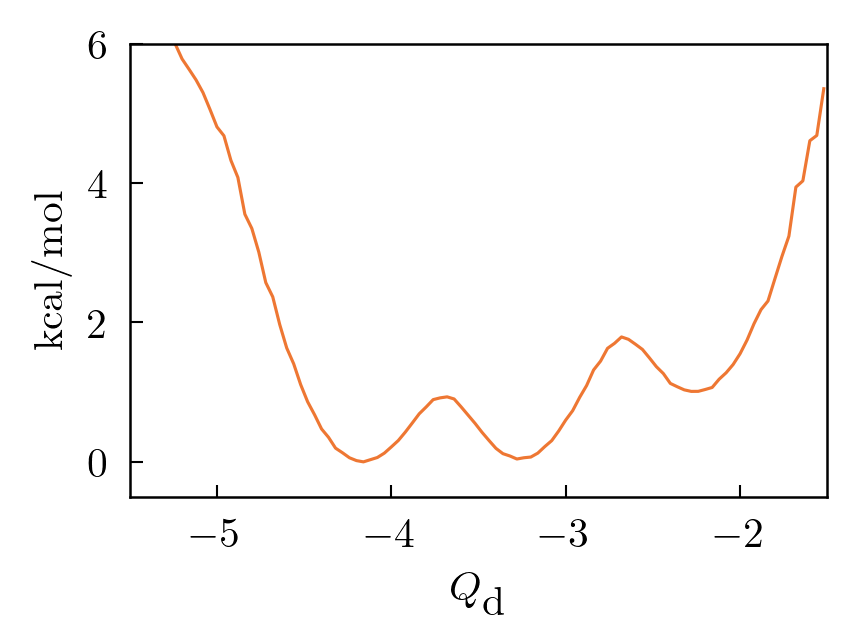

In [38]:
qc = (qe[1:] + qe[:-1]) / 2
min_energy = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_energy

plt.figure(dpi=300, figsize=(3, 2))
plt.plot(qc, pmf * 0.593)
plt.xlabel(r"$Q_{\textrm{d}}$")
plt.ylabel("kcal/mol")
plt.xlim([-5.5, -1.5])
plt.ylim([-0.5, 6])

# MBAR analysis (positive)

In [40]:
pot_energies = np.load(f"{DATA_DIR}/pos_pot_energies.npy")
cvs = np.load(f"{DATA_DIR}/pos_cvs.npy")
print(pot_energies.shape, cvs.shape)

(191, 30000) (191, 30000, 4)


In [41]:
dq_post = np.load("/project/dinner/scguo/ci-vsd/data/rong_remd/pos_dq.npy")

(array([   766.,  28621.,  72963., 102864.,  82335.,  80768.,  75900.,
         60351.,  66589.,   1843.]),
 array([-5.67594365, -5.23253373, -4.7891238 , -4.34571388, -3.90230395,
        -3.45889403, -3.0154841 , -2.57207418, -2.12866425, -1.68525433,
        -1.2418444 ]),
 <BarContainer object of 10 artists>)

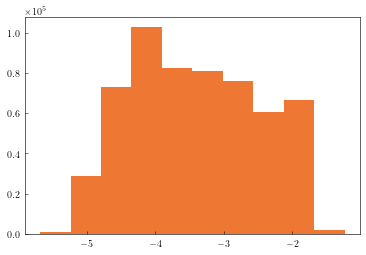

In [42]:
plt.hist(dq_post.flatten())

In [43]:
N_max = pot_energies.shape[1]  # max number of frames from window
N_k = np.ones(nwin, dtype=int) * N_max  # N_k[k] is the number of snapshots from umbrella simulation k

ds_kn = np.zeros((nwin, N_max, 2), dtype=float)  # ds[k, n] is the
u_kn = np.zeros(
    (nwin, N_max), dtype=float
)  # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
g_k = np.zeros(nwin, dtype=int)  # number of uncorrelated samples per window

start_frame = 0
skip = 10
u_kn = u_kn[:, start_frame::skip]
ds_kn = cvs[:, start_frame::skip, :2]
N_max = u_kn.shape[1]
N_k = np.ones(nwin, dtype=int) * N_max

In [44]:
u_kln = np.zeros((nwin, nwin, N_max), dtype=float)
for k in range(nwin):
    for l in range(nwin):
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k, l] = u_kn[k] + 0.5 * beta0 * (
            k1[l] * (ds_kn[k, :, 0] - cx1[l]) ** 2 + k2[l] * (ds_kn[k, :, 1] - cx2[l]) ** 2
        )

In [45]:
mbar_pos = pymbar.MBAR(u_kln, N_k, verbose=True)

In [46]:
log_w_nb = mbar._computeUnnormalizedLogWeights(np.zeros(mbar_pos.N)) # compute free energy with no bias
max_log_w_nb = np.max(log_w_nb)  # to prevent underflow.
w_nb_pos = np.exp(log_w_nb - max_log_w_nb)
# w_nb = w_nb / np.sum(w_nb)  # normalize the weights

In [47]:
dens = extq.projection.density2d(ds_kn[..., 0], ds_kn[..., 1], w_nb_pos.reshape((mbar.K, -1)), xlim, ylim) 

/scratch/local/jobs/5704280/ipykernel_1238939/1650888629.py:2: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens) - min_energy


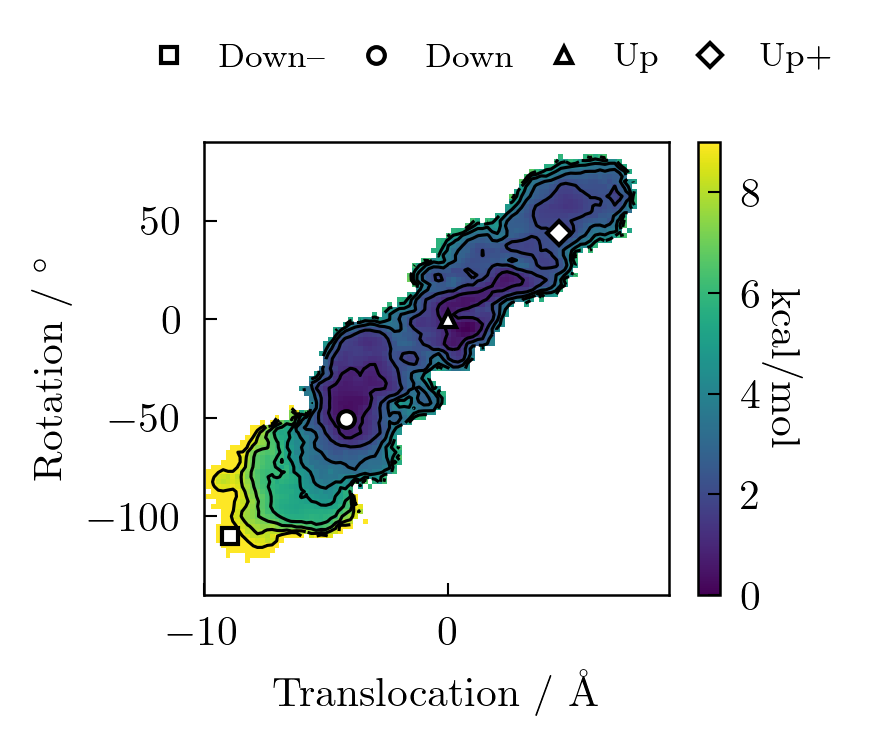

In [48]:
min_energy = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_energy

fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
pc = plt.pcolormesh(xlim, ylim, pmf.T * 0.593, vmax=9)
cb = plt.colorbar(pc)
cb.set_label("kcal/mol", rotation=-90, labelpad=10)
xc = (xlim[1:] + xlim[:-1]) / 2
yc = (ylim[1:] + ylim[:-1]) / 2
plt.contour(xc, yc, pmf.T * 0.593, colors='black', levels=np.arange(10))
plotting.format_cvs(ax, centroids=False, ms=4, zorder=5)
fig.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=0.5,
    handletextpad=0.5,
    fontsize=8,
)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xlabel("Translocation / Å")
ax.set_ylabel("Rotation / $^\circ$")
ax.label_outer()

In [51]:
qe = np.linspace(-5.5, -1.5, 101)
dens = extq.projection.density1d(dq_post, w_nb_pos.reshape((mbar_pos.K, -1)), qe)

(-0.5, 6.0)

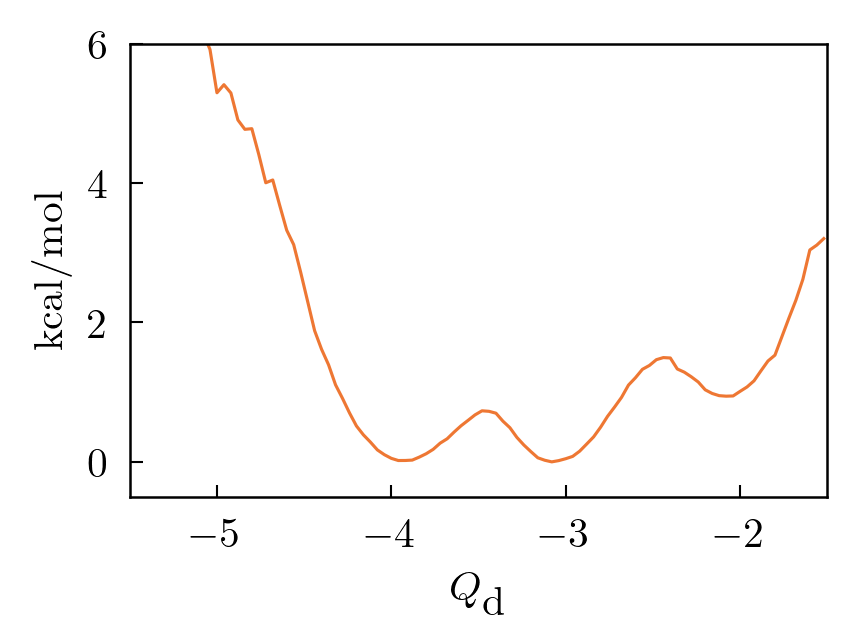

In [52]:
qc = (qe[1:] + qe[:-1]) / 2
min_energy = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_energy

plt.figure(dpi=300, figsize=(3, 2))
plt.plot(qc, pmf * 0.593)
plt.xlabel(r"$Q_{\textrm{d}}$")
plt.ylabel("kcal/mol")
plt.xlim([-5.5, -1.5])
plt.ylim([-0.5, 6])

# MBAR analysis (negative)

In [40]:
pot_energies = np.load(f"{DATA_DIR}/pos_pot_energies.npy")
cvs = np.load(f"{DATA_DIR}/pos_cvs.npy")
print(pot_energies.shape, cvs.shape)

(191, 30000) (191, 30000, 4)


In [41]:
dq_post = np.load("/project/dinner/scguo/ci-vsd/data/rong_remd/pos_dq.npy")

(array([   766.,  28621.,  72963., 102864.,  82335.,  80768.,  75900.,
         60351.,  66589.,   1843.]),
 array([-5.67594365, -5.23253373, -4.7891238 , -4.34571388, -3.90230395,
        -3.45889403, -3.0154841 , -2.57207418, -2.12866425, -1.68525433,
        -1.2418444 ]),
 <BarContainer object of 10 artists>)

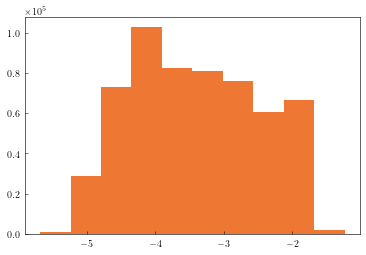

In [42]:
plt.hist(dq_post.flatten())

In [43]:
N_max = pot_energies.shape[1]  # max number of frames from window
N_k = np.ones(nwin, dtype=int) * N_max  # N_k[k] is the number of snapshots from umbrella simulation k

ds_kn = np.zeros((nwin, N_max, 2), dtype=float)  # ds[k, n] is the
u_kn = np.zeros(
    (nwin, N_max), dtype=float
)  # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
g_k = np.zeros(nwin, dtype=int)  # number of uncorrelated samples per window

start_frame = 0
skip = 10
u_kn = u_kn[:, start_frame::skip]
ds_kn = cvs[:, start_frame::skip, :2]
N_max = u_kn.shape[1]
N_k = np.ones(nwin, dtype=int) * N_max

In [44]:
u_kln = np.zeros((nwin, nwin, N_max), dtype=float)
for k in range(nwin):
    for l in range(nwin):
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k, l] = u_kn[k] + 0.5 * beta0 * (
            k1[l] * (ds_kn[k, :, 0] - cx1[l]) ** 2 + k2[l] * (ds_kn[k, :, 1] - cx2[l]) ** 2
        )

In [45]:
mbar_pos = pymbar.MBAR(u_kln, N_k, verbose=True)

In [46]:
log_w_nb = mbar._computeUnnormalizedLogWeights(np.zeros(mbar_pos.N)) # compute free energy with no bias
max_log_w_nb = np.max(log_w_nb)  # to prevent underflow.
w_nb_pos = np.exp(log_w_nb - max_log_w_nb)
# w_nb = w_nb / np.sum(w_nb)  # normalize the weights

In [47]:
dens = extq.projection.density2d(ds_kn[..., 0], ds_kn[..., 1], w_nb_pos.reshape((mbar.K, -1)), xlim, ylim) 

/scratch/local/jobs/5704280/ipykernel_1238939/1650888629.py:2: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens) - min_energy


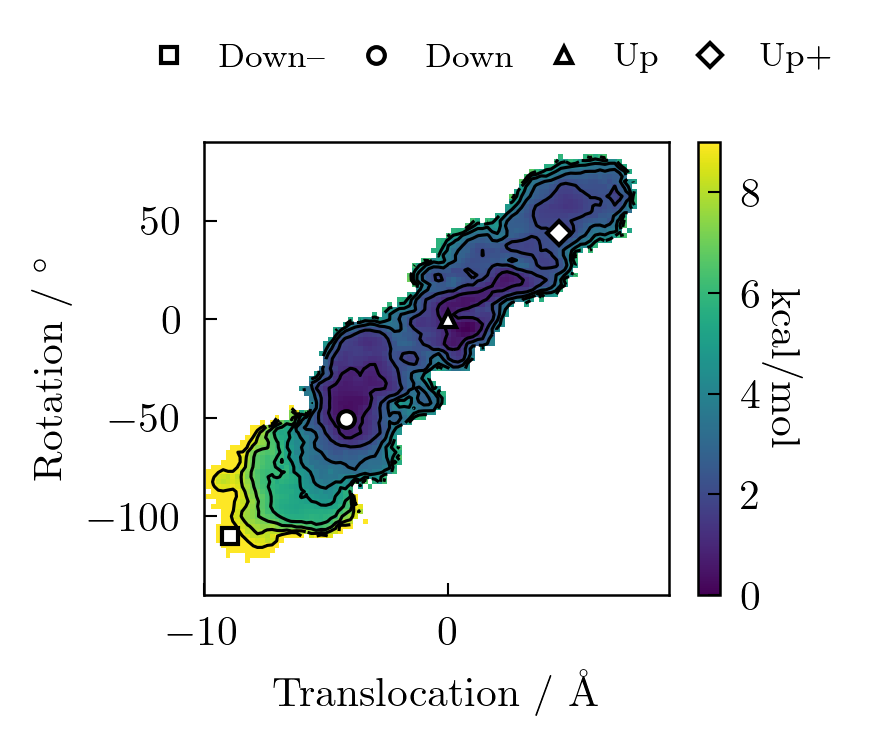

In [48]:
min_energy = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_energy

fig = plt.figure(dpi=300, figsize=(2.5, 2))
ax = plt.gca()
pc = plt.pcolormesh(xlim, ylim, pmf.T * 0.593, vmax=9)
cb = plt.colorbar(pc)
cb.set_label("kcal/mol", rotation=-90, labelpad=10)
xc = (xlim[1:] + xlim[:-1]) / 2
yc = (ylim[1:] + ylim[:-1]) / 2
plt.contour(xc, yc, pmf.T * 0.593, colors='black', levels=np.arange(10))
plotting.format_cvs(ax, centroids=False, ms=4, zorder=5)
fig.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=0.5,
    handletextpad=0.5,
    fontsize=8,
)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xlabel("Translocation / Å")
ax.set_ylabel("Rotation / $^\circ$")
ax.label_outer()

In [51]:
qe = np.linspace(-5.5, -1.5, 101)
dens = extq.projection.density1d(dq_post, w_nb_pos.reshape((mbar_pos.K, -1)), qe)

(-0.5, 6.0)

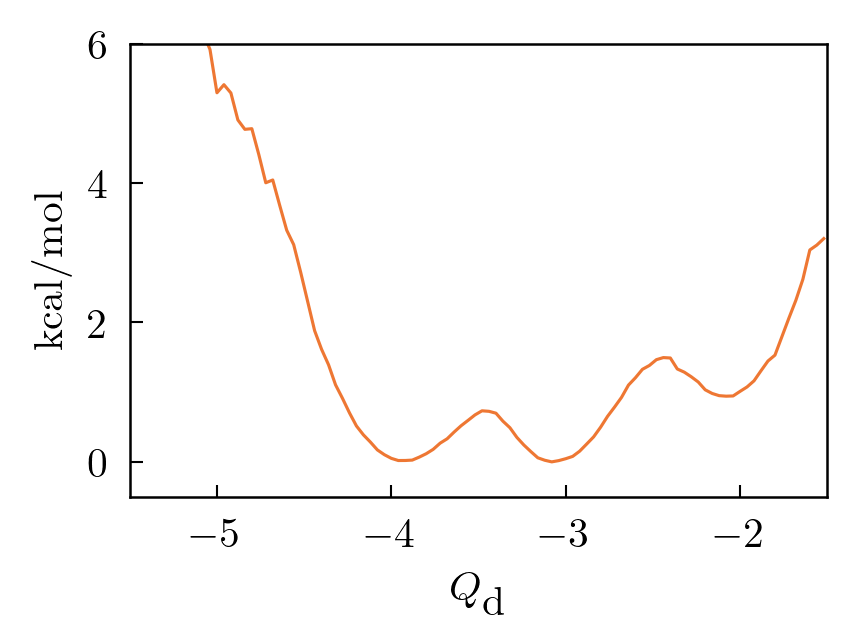

In [52]:
qc = (qe[1:] + qe[:-1]) / 2
min_energy = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_energy

plt.figure(dpi=300, figsize=(3, 2))
plt.plot(qc, pmf * 0.593)
plt.xlabel(r"$Q_{\textrm{d}}$")
plt.ylabel("kcal/mol")
plt.xlim([-5.5, -1.5])
plt.ylim([-0.5, 6])